In [46]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [47]:
front_2Dcoord = np.load('front_image.npy', allow_pickle=True)
back_2Dcoord = np.load('back_image.npy', allow_pickle=True)
front_img = cv2.imread('front.png')

(12, 2) (12, 2)


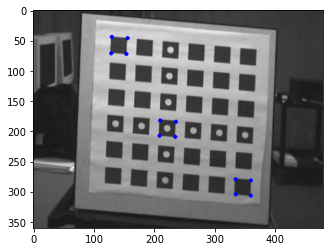

In [48]:
#visualization
print(front_2Dcoord.shape, back_2Dcoord.shape)
from copy import deepcopy
vis_img = deepcopy(front_img)
for i in range(front_2Dcoord.shape[0]):
    cv2.circle(vis_img, (int(front_2Dcoord[i,0]), int(front_2Dcoord[i,1])), 2, (255,0,0), 2)
plt.imshow(vis_img[:,:,::-1])
plt.show()

In [49]:
# ------------TODO----------------
# Compute corresponding 3D coordinate
# ------------TODO----------------
front_3Dcoord = np.zeros((12, 3))
back_3Dcoord = np.zeros((12, 3))
p = [(0, 0), (2, 3), (5, 5)]
q = [(0, 0), (50, 0), (50, 50), (0, 50)]
for i in range(3):
    for j in range(4):
        front_3Dcoord[i * 4 + j, :] = p[i][0] * 80 + q[j][0], p[i][1] * 80 + q[j][1], 0
        back_3Dcoord[i * 4 + j, :] = p[i][0] * 80 + q[j][0], p[i][1] * 80 + q[j][1], 150

all_2Dcoord = np.concatenate((front_2Dcoord, back_2Dcoord), axis=0)
all_3Dcoord = np.concatenate((front_3Dcoord, back_3Dcoord), axis=0)
#print(all_2Dcoord.shape, all_3Dcoord.shape)
#print(all_2Dcoord)
#print(all_3Dcoord)

In [50]:
# ------------TODO----------------
# Construct the Equation Pm=0 and solve m
# ------------TODO----------------

P = np.zeros((48, 12))
m = np.zeros((12, 1))
for i in range(24):
    P[i*2, 0:3] = all_3Dcoord[i, 0:3]
    P[i*2, 3] = 1
    P[i*2, 8:11] = all_3Dcoord[i, 0:3] * (-all_2Dcoord[i][0])
    P[i*2, 11] = -all_2Dcoord[i][0]
    
    P[i*2+1, 4:7] = all_3Dcoord[i, 0:3]
    P[i*2+1, 7] = 1
    P[i*2+1, 8:11] = all_3Dcoord[i, 0:3] * (-all_2Dcoord[i][1])
    P[i*2+1, 11] = -all_2Dcoord[i][1]
U, S, V = np.linalg.svd(P)
m = V[-1]

In [51]:
# ------------TODO----------------
# Solve K, and [R T] from m
# ------------TODO----------------

M_hat = np.zeros((3,4))
M_hat[0,:] = m[0:4]
M_hat[1,:] = m[4:8]
M_hat[2,:] = m[8:12]
A_hat = M_hat[:, 0:3]
b_hat = M_hat[:, 3:4]
rho = 1.0 / np.linalg.norm(A_hat[2])
c_x = (rho ** 2) * np.dot(A_hat[0], A_hat[2])
c_y = (rho ** 2) * np.dot(A_hat[1], A_hat[2])
cos_theta = np.dot(np.cross(A_hat[1], A_hat[2]), np.cross(A_hat[2], A_hat[0])) / np.linalg.norm(np.cross(A_hat[1], A_hat[2])) / np.linalg.norm(np.cross(A_hat[2], A_hat[0]))
sin_theta = (1.0 - cos_theta ** 2) ** 0.5
cot_theta = cos_theta / sin_theta
alpha = (rho ** 2) * np.linalg.norm(np.cross(A_hat[0], A_hat[2])) * sin_theta
beta = (rho ** 2) * np.linalg.norm(np.cross(A_hat[1], A_hat[2])) * sin_theta

K = np.zeros((3, 3))
R = np.zeros((3, 3))
T = np.zeros((3, 1))

K = np.array([[alpha, -alpha * cot_theta, c_x], [0, beta / sin_theta, c_y], [0, 0, 1]])
R[0, :] = np.cross(A_hat[1], A_hat[2]) / np.linalg.norm(np.cross(A_hat[1], A_hat[2]))
R[2, :] = A_hat[2] / np.linalg.norm(A_hat[2])
R[1, :] = np.cross(R[2, :], R[0, :])
T = np.reshape(rho * np.matmul(np.linalg.inv(K), b_hat), -1)


In [52]:
# save results
save_dict = {'3Dcoord': all_3Dcoord, 'P':P, 'm':m, 'K':K, 'R':R, 'T':T}
np.save('../results/calibr', save_dict)

# The reference answer of T should be [383001.8386981  -67357.81794783  67071.11338303]
# The results are very strange because the data is fake.